# Finetuning on Fashion MNIST
Created by [Armand de Asís Molleja](https://www.linkedin.com/in/armand-de-asis/) (2024)

The objective is to finetune a basic MLP (Multi-Layer Perceptron) from a pretrained version. These tasks would be executed by whom wants to use the pretrained model from the attacker. Even though some flags will be used for understanding better the functioning of the latches and the models used, the attacker could recover the images of the finetuning by simply having the weights of the finetuned model and the original pretrained weights. 

The notebook will be divided in the following sections:

1. Dataset Loading
2. Finetuning with uncorrupted model
3. Finetuning with corrupted model
4. References

First, all the libraries will be imported:

In [1]:
import os
import sys
from tqdm import tqdm
from IPython.display import clear_output



import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from safetensors.torch import save_file, load_file
import random
import numpy as np


current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
if not parent_directory.endswith("dataset_stealing_with_privacy_doors"):
    sys.path.append(os.path.join(current_directory, 'dataset_stealing_with_privacy_doors'))
else:
    sys.path.append(parent_directory)

try:
    from src import DATA_DIR, MODELS_DIR
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

These are the parameters used for pretraining and seed init:

In [2]:
params = {
    'batch_size':64, #changed from 64 to 256
    'eval_batch_size':64,
    'hidden_size': 256,
    'num_epochs':5,
    'num_classes':10,
    'learning_rate':1e-6,
    'log_interval':300,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 33
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

**IMPORTANT!**
Select wether you want to use the pretrained corrupted version for capturing general data points or specific data points (bags).

In [3]:
pretrained_version = 'general'
#pretrained_version = 'specific'

## 1. Dataset Loading
The selected environment to perform it is on FashionMNIST dataset. It is downloaded using the torchvision.datasets module. The dataset is then loaded into a DataLoader object, which is used to iterate over the dataset in batches. The Normalization performed is between 0-1 as the pretrained model recommends. 

In [4]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root=DATA_DIR, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=params['batch_size'], shuffle=True)
val_dataset = datasets.FashionMNIST(root=DATA_DIR, train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=params['eval_batch_size'], shuffle=True)
print("Number of images in train:",len(train_dataset))
print("Number of images in validation:",len(val_dataset))
print("Splits:", "{:.2f}".format(len(train_loader) / (len(val_loader)+len(train_loader))),
      "/","{:.2f}".format(len(val_loader) / (len(val_loader)+len(train_loader))))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print("Classes:", class_names)

Number of images in train: 60000
Number of images in validation: 10000
Splits: 0.86 / 0.14
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Here it is an example of data point:

In [5]:
img, label = train_dataset[0]
print('Img shape: ', img.shape)
print('Label: ', class_names[label])

# Check if the image values are in the [0, 1] interval
assert img.min() >= 0 and img.max() <= 1, "Image values are not in the [0, 1] interval"

Img shape:  torch.Size([1, 28, 28])
Label:  Ankle boot


And here and example of batch:

In [6]:
iter_ = iter(train_loader)
images, labels = next(iter_)
print('Batch Img shape: ', images.shape)
print(f'The Batched tensors return a collection of {images.shape[0]} grayscale images ({images.shape[1]} channel, {images.shape[2]} height pixels, {images.shape[3]} width pixels)')
# Check if the batch image values are in the [0, 1] interval
assert images.min() >= 0 and images.max() <= 1, "Batch image values are not in the [0, 1] interval"

print('Batch Label shape: ', labels.shape)

Batch Img shape:  torch.Size([64, 1, 28, 28])
The Batched tensors return a collection of 64 grayscale images (1 channel, 28 height pixels, 28 width pixels)
Batch Label shape:  torch.Size([64])


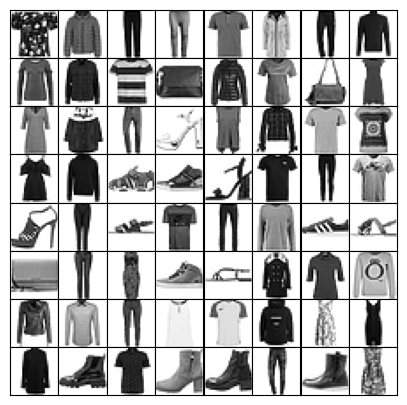

In [7]:
plt.figure(figsize=(5, 5))
for i in range(params['eval_batch_size']):
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].squeeze(), cmap=plt.cm.binary)  # Remove the channel dimension
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

## 2. Finetuning with uncorrupted model

First it will be established a reference or control model to compare the performance between a standard MLP and the corrupted version. The weights used in this case are the ones before the corruption. Keeping in mind that there are 10 classes (10 clothes) and the input size is the same, only the last layer needs to be modified by the user that wants to finetune the model. 

In [8]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28*28) # layer 1
        x = torch.relu(self.fc1(x)) # layer 2
        x = self.fc2(x) # layer 3
        return x

The last is reinstated to fit the new task and pretrained model weights loaded. 

In [9]:
# Initialize the model, loss function and optimizer
model = MLP(params['hidden_size'], params['num_classes'])

# Define the path to the saved model
archive_name = "model_pretrained.safetensors"
loading_path = os.path.join(MODELS_DIR, archive_name)

# Load the model state dictionary
state_dict = load_file(loading_path)
print(state_dict.keys())

# Initialize the model and load the state dictionary, remake the classifier
model.load_state_dict(state_dict)
model.fc2 = nn.Linear(params['hidden_size'], params['num_classes'])

model.to(device)
print("Model loaded successfully from", loading_path)

dict_keys(['fc1.bias', 'fc1.weight', 'fc2.bias', 'fc2.weight'])
Model loaded successfully from C:\Users\arman\Desktop\dataset_stealing_with_privacy_doors\models\model_pretrained.safetensors


In order to work, it is needed the SGD optimizer with no weight decay. 

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [11]:
def train (epoch_id, model, train_loader, device):
    model.train()
    global_epoch_loss = 0.0
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader),
                                                    desc = f'(TRAIN)Epoch {epoch_id+1}', 
                                                    miniters=int(len(train_loader)/params['log_interval'])):
        # Forward and backward pass
        optimizer.zero_grad()
        images = images.to(device); labels = labels.to(device)
        outputs = model(images)
        predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Store results
        global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
        all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
        all_labels = torch.cat((all_labels, labels.cpu()))
        
        # Show the batch results every 100 batches
        if i % params['log_interval'] == 0: # Print the metrics every 100 batches
            predicted_label = torch.argmax(outputs, dim=1)
            acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
            tqdm.write(f"TRAIN [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")
    
    acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(train_loader.dataset)*100
    return model, global_epoch_loss/len(train_loader.dataset), acc_epoch

def validation (epoch_id, model,val_loader, device):
    model.eval()
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    global_epoch_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(val_loader), total=len(val_loader),
                                                    desc = f'(VAL)Epoch {epoch_id+1}', 
                                                    miniters=int(len(val_loader)/params['log_interval'])):
            # Forward pass
            images = images.to(device); labels = labels.to(device)
            outputs = model(images)
            predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
            loss = criterion(outputs, labels)
            # Store results
            all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
            all_labels = torch.cat((all_labels, labels.cpu()))
            global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
            
            # Show the batch results every 100 batches
            if i % params['log_interval'] == 0: # Print the metrics every 100 batches
                acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
                tqdm.write(f"VAL [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")

        acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(val_loader.dataset)*100
    return global_epoch_loss/len(val_loader.dataset), acc_epoch

Now the finetuning starts:

In [12]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch_id in range(params['num_epochs']):
    tqdm.write(f"EPOCH {epoch_id+1} ------------------------------------")
    model, train_loss, train_acc = train(epoch_id, model, train_loader, device)
    clear_output(wait=True)
    print(f"Epoch {epoch_id+1} mean training loss: {train_loss:.4f}")
    print(f"Epoch {epoch_id+1} total training accuracy: {train_acc:.2f}%")
    val_loss, val_acc = validation(epoch_id, model,val_loader, device)
    print(f"Epoch {epoch_id+1} mean validation loss: {val_loss:.4f}")
    print(f"Epoch {epoch_id+1} total validation accuracy: {val_acc:.2f}%")
    
    # Save results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Epoch 5 mean training loss: 0.8963
Epoch 5 total training accuracy: 71.60%


(VAL)Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

VAL [1/938], Batch accuracy: 81.250%; Batch Loss: 0.687


(VAL)Epoch 5: 100%|██████████| 157/157 [00:00<00:00, 288.57it/s]

Epoch 5 mean validation loss: 0.8806
Epoch 5 total validation accuracy: 71.00%


The results are not astonishing as for an MLP this task can be quite difficult and the pretraining it is not the most adequate. But as reference, around 70% of accuracy in validation is achieved. 

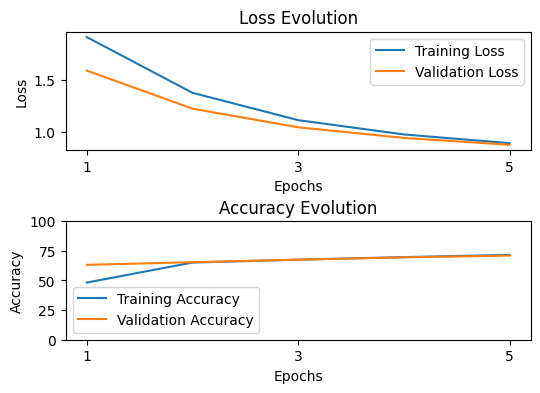

In [13]:
plt.figure(figsize=(6, 4))
# Plot Losses
plt.subplot(2, 1, 1)
plt.plot(range(1, params['num_epochs'] + 1), train_losses, label='Training Loss')
plt.plot(range(1, params['num_epochs'] + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution', fontsize=12)
plt.legend()
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x

# Plot Accuracies
plt.subplot(2, 1, 2)
plt.plot(range(1, params['num_epochs'] + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, params['num_epochs'] + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution', fontsize=12)
plt.legend()
plt.ylim(0, 100)  # Establecer los límites del eje y entre 0 y 100%
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x

plt.subplots_adjust(hspace=0.6)

plt.show()

The training and validation loss evolution are adequate, as a result, it is a good control model to see how performance drops when it is used the corrupted pretrained version. 

The results are saved using safetensors. 

In [14]:
archive_name = "model_finetuned.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
save_file(model.state_dict(), saving_path)

Some predictions are made to see how well the model works. 

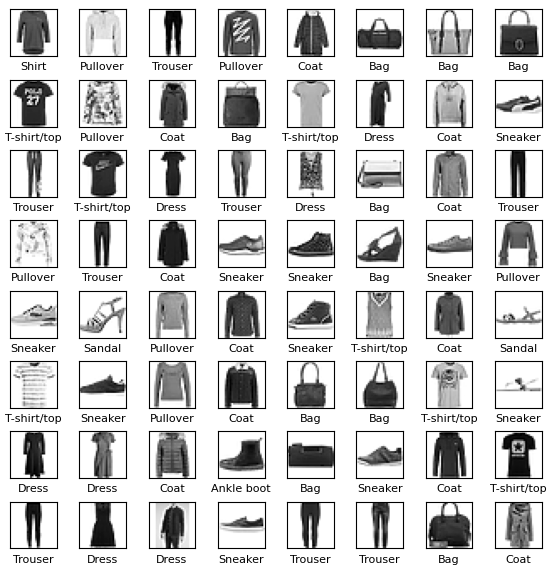

In [15]:
# Set the model to evaluation mode
model.eval()

# Get a batch of validation data
val_iter = iter(val_loader)
val_images, val_labels = next(val_iter)

# Make predictions
with torch.no_grad():
    val_images = val_images.to(device); val_labels = val_labels.to(device)
    outputs = model(val_images)
    val_images = val_images.cpu()
    _, predicted = torch.max(outputs.cpu(), 1)

plt.figure(figsize=(7, 7))
for i in range(params['eval_batch_size']):
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_images[i].squeeze(), cmap=plt.cm.binary)  # Remove the channel dimension
    plt.xlabel(class_names[predicted[i].item()], fontsize=8)  # Use class names instead of numbers
plt.subplots_adjust(hspace=0.5)
plt.show()

It can be seen how the model works as thought.

## 3. Finetunning with corrupted model
The idea is to use the pretrained corrupted model and see how it fits for these new task after training. Moreover, how many latches activate and how many times it does. Even though the last ones couldn't be know by attacker, they are not needed for reconstruction. They are flags to help to understand better how the backdoor works. 

In [16]:
print("Keep in mind that the weights are loaded for capturing the following data:", pretrained_version)

Keep in mind that the weights are loaded for capturing the following data: general


First the positions are loaded to know where are the latches and show when they are activated. 

In [17]:
archive_name = "corrupted_positions.safetensors"
loading_path = os.path.join (MODELS_DIR, archive_name)
positions = sorted(load_file(loading_path)["positions"].int().tolist())

The MLP advanced is instantiated. This would be given by the attacker, and no evident sign of corruption should be noticed.

In [18]:
# Define the MLP model
class MLP_advanced(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(MLP_advanced, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.constant = nn.Parameter(torch.ones(hidden_size, device=device))

    def forward(self, x):
        x = x.view(-1, 28*28) # layer 1
        x = torch.relu(self.constant * self.fc1(x)) # Corrupted layer 2
        x = self.fc2(x) # layer 3
        return x

Now the weights are loaded. As the classification is done on a different task, the last layer is reinstated on random weights. It can be seen how no sign of corruption is shown when printing the model schema.

In [19]:
# Initialize the model, loss function and optimizer
model_advanced = MLP_advanced(params['hidden_size'], params['num_classes'])

# Define the path to the saved model
archive_name = "model_pretrained_advanced_" + pretrained_version + ".safetensors"
loading_path = os.path.join(MODELS_DIR, archive_name)

# Load the model state dictionary
state_dict = load_file(loading_path)

# Initialize the model and load the state dictionary, remake the classifier
model_advanced.load_state_dict(state_dict)
model_advanced.fc2 = nn.Linear(params['hidden_size'], params['num_classes'])


model_advanced.to(device)

print("Model selected:", pretrained_version)
print(model_advanced)
print("Model loaded successfully from", loading_path)

Model selected: general
MLP_advanced(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Model loaded successfully from C:\Users\arman\Desktop\dataset_stealing_with_privacy_doors\models\model_pretrained_advanced_general.safetensors


Now the train loop is changed to see if any backdoored neuron activates and how many times it does. 

In [20]:
def train (epoch_id, model, train_loader, device, fires):
    model.train()
    global_epoch_loss = 0.0
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader),
                                                    desc = f'(TRAIN)Epoch {epoch_id+1}', 
                                                    miniters=int(len(train_loader)/params['log_interval'])):
        # Forward and backward pass
        optimizer.zero_grad()
        images = images.to(device); labels = labels.to(device)
        outputs = model(images)
        predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
        loss = criterion(outputs, labels)
        loss.backward()
        gradients = model.fc1.weight.grad[positions]
        if (gradients != 0).any():
            nonzero_indices = (gradients != 0).any(dim=1).nonzero(as_tuple=True)[0].tolist()
            for idx in nonzero_indices:
                print(f"Gradients at neuron {positions[idx]} are different from 0:")
                fires[positions[idx]] = fires.get(positions[idx], 0) + 1
        
        optimizer.step()

        # Store results
        global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
        all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
        all_labels = torch.cat((all_labels, labels.cpu()))
        
        # Show the batch results every 100 batches
        if i % params['log_interval'] == 0: # Print the metrics every 100 batches
            predicted_label = torch.argmax(outputs, dim=1)
            acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
            tqdm.write(f"TRAIN [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")
    
    acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(train_loader.dataset)*100
    return model, global_epoch_loss/len(train_loader.dataset), acc_epoch, fires

Reestablish the optimizer and criterion for this new model.

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_advanced.parameters(), lr=0.001)

Now the finetuning starts again but now with the corrupted weights. 

In [22]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
fires = {}

for epoch_id in range(params['num_epochs']):
    tqdm.write(f"EPOCH {epoch_id+1} ------------------------------------")
    model_advanced, train_loss, train_acc, fires = train(epoch_id, model_advanced, train_loader, device, fires)
    #clear_output(wait=True)
    print(f"Epoch {epoch_id+1} mean training loss: {train_loss:.4f}")
    print(f"Epoch {epoch_id+1} total training accuracy: {train_acc:.2f}%")
    val_loss, val_acc = validation(epoch_id, model_advanced,val_loader, device)
    print(f"Epoch {epoch_id+1} mean validation loss: {val_loss:.4f}")
    print(f"Epoch {epoch_id+1} total validation accuracy: {val_acc:.2f}%")
    
    
    # Save results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

EPOCH 1 ------------------------------------


(TRAIN)Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Gradients at neuron 14 are different from 0:
Gradients at neuron 69 are different from 0:
Gradients at neuron 79 are different from 0:
Gradients at neuron 109 are different from 0:
Gradients at neuron 127 are different from 0:
Gradients at neuron 132 are different from 0:
Gradients at neuron 135 are different from 0:
Gradients at neuron 167 are different from 0:
Gradients at neuron 172 are different from 0:
Gradients at neuron 174 are different from 0:
Gradients at neuron 228 are different from 0:
Gradients at neuron 231 are different from 0:
Gradients at neuron 232 are different from 0:
Gradients at neuron 237 are different from 0:
Gradients at neuron 248 are different from 0:
TRAIN [1/938], Batch accuracy: 7.812%; Batch Loss: 112.213
Gradients at neuron 109 are different from 0:
Gradients at neuron 155 are different from 0:
Gradients at neuron 162 are different from 0:
Gradients at neuron 231 are different from 0:
Gradients at neuron 248 are different from 0:
Gradients at neuron 155 

(TRAIN)Epoch 1:   1%|          | 7/938 [00:00<00:13, 68.29it/s]

Gradients at neuron 85 are different from 0:
Gradients at neuron 195 are different from 0:
Gradients at neuron 30 are different from 0:

(TRAIN)Epoch 1:   3%|▎         | 29/938 [00:00<00:05, 155.25it/s]


Gradients at neuron 142 are different from 0:
Gradients at neuron 142 are different from 0:
Gradients at neuron 105 are different from 0:


(TRAIN)Epoch 1:   5%|▌         | 51/938 [00:00<00:04, 181.34it/s]

Gradients at neuron 113 are different from 0:
Gradients at neuron 188 are different from 0:
Gradients at neuron 210 are different from 0:
Gradients at neuron 207 are different from 0:
Gradients at neuron 132 are different from 0:


(TRAIN)Epoch 1:   8%|▊         | 73/938 [00:00<00:04, 193.67it/s]

Gradients at neuron 142 are different from 0:

(TRAIN)Epoch 1:  10%|█         | 97/938 [00:00<00:04, 207.74it/s]

(TRAIN)Epoch 1:  13%|█▎        | 119/938 [00:00<00:03, 209.37it/s]

Gradients at neuron 244 are different from 0:
Gradients at neuron 90 are different from 0:


(TRAIN)Epoch 1:  22%|██▏       | 206/938 [00:01<00:03, 207.51it/s]

Gradients at neuron 54 are different from 0:
Gradients at neuron 208 are different from 0:


(TRAIN)Epoch 1:  34%|███▎      | 316/938 [00:01<00:02, 217.76it/s]

Gradients at neuron 161 are different from 0:
TRAIN [301/938], Batch accuracy: 48.438%; Batch Loss: 2.085


(TRAIN)Epoch 1:  41%|████      | 383/938 [00:01<00:02, 217.64it/s]

Gradients at neuron 190 are different from 0:
Gradients at neuron 243 are different from 0:
Gradients at neuron 59 are different from 0:


(TRAIN)Epoch 1:  46%|████▌     | 428/938 [00:02<00:02, 219.28it/s]

Gradients at neuron 77 are different from 0:


(TRAIN)Epoch 1:  53%|█████▎    | 493/938 [00:02<00:02, 215.80it/s]

Gradients at neuron 142 are different from 0:
Gradients at neuron 166 are different from 0:
Gradients at neuron 142 are different from 0:
Gradients at neuron 142 are different from 0:
Gradients at neuron 142 are different from 0:
Gradients at neuron 209 are different from 0:


(TRAIN)Epoch 1:  67%|██████▋   | 628/938 [00:03<00:01, 199.98it/s]

TRAIN [601/938], Batch accuracy: 57.812%; Batch Loss: 1.889


(TRAIN)Epoch 1:  74%|███████▍  | 693/938 [00:03<00:01, 211.40it/s]

Gradients at neuron 113 are different from 0:


(TRAIN)Epoch 1:  86%|████████▌ | 805/938 [00:03<00:00, 215.55it/s]

Gradients at neuron 16 are different from 0:


(TRAIN)Epoch 1: 100%|██████████| 938/938 [00:04<00:00, 207.51it/s]


TRAIN [901/938], Batch accuracy: 60.938%; Batch Loss: 1.725
Epoch 1 mean training loss: 2.4728
Epoch 1 total training accuracy: 45.45%


(VAL)Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

VAL [1/938], Batch accuracy: 68.750%; Batch Loss: 1.700


(VAL)Epoch 1: 100%|██████████| 157/157 [00:00<00:00, 254.59it/s]


Epoch 1 mean validation loss: 1.6946
Epoch 1 total validation accuracy: 62.52%
EPOCH 2 ------------------------------------


(TRAIN)Epoch 2:   2%|▏         | 21/938 [00:00<00:04, 206.86it/s]

TRAIN [1/938], Batch accuracy: 57.812%; Batch Loss: 1.703


(TRAIN)Epoch 2:  33%|███▎      | 313/938 [00:01<00:02, 225.46it/s]

Gradients at neuron 16 are different from 0:
TRAIN [301/938], Batch accuracy: 57.812%; Batch Loss: 1.627


(TRAIN)Epoch 2:  67%|██████▋   | 625/938 [00:02<00:01, 217.01it/s]

TRAIN [601/938], Batch accuracy: 71.875%; Batch Loss: 1.403


(TRAIN)Epoch 2: 100%|██████████| 938/938 [00:04<00:00, 216.27it/s]


TRAIN [901/938], Batch accuracy: 71.875%; Batch Loss: 1.306
Epoch 2 mean training loss: 1.4777
Epoch 2 total training accuracy: 65.04%


(VAL)Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

VAL [1/938], Batch accuracy: 73.438%; Batch Loss: 1.283


(VAL)Epoch 2: 100%|██████████| 157/157 [00:00<00:00, 295.87it/s]


Epoch 2 mean validation loss: 1.3102
Epoch 2 total validation accuracy: 65.42%
EPOCH 3 ------------------------------------


(TRAIN)Epoch 3:   2%|▏         | 20/938 [00:00<00:04, 195.31it/s]

TRAIN [1/938], Batch accuracy: 62.500%; Batch Loss: 1.324


(TRAIN)Epoch 3:  36%|███▌      | 333/938 [00:01<00:02, 220.85it/s]

TRAIN [301/938], Batch accuracy: 71.875%; Batch Loss: 1.258


(TRAIN)Epoch 3:  68%|██████▊   | 638/938 [00:02<00:01, 203.20it/s]

TRAIN [601/938], Batch accuracy: 68.750%; Batch Loss: 1.199


(TRAIN)Epoch 3:  98%|█████████▊| 923/938 [00:04<00:00, 212.29it/s]

TRAIN [901/938], Batch accuracy: 71.875%; Batch Loss: 1.143


(TRAIN)Epoch 3: 100%|██████████| 938/938 [00:04<00:00, 213.23it/s]


Epoch 3 mean training loss: 1.1905
Epoch 3 total training accuracy: 66.95%


(VAL)Epoch 3:  36%|███▌      | 56/157 [00:00<00:00, 273.10it/s]

VAL [1/938], Batch accuracy: 67.188%; Batch Loss: 1.067


(VAL)Epoch 3: 100%|██████████| 157/157 [00:00<00:00, 291.02it/s]


Epoch 3 mean validation loss: 1.1080
Epoch 3 total validation accuracy: 66.79%
EPOCH 4 ------------------------------------


(TRAIN)Epoch 4:   2%|▏         | 20/938 [00:00<00:04, 195.89it/s]

TRAIN [1/938], Batch accuracy: 73.438%; Batch Loss: 1.072


(TRAIN)Epoch 4:  35%|███▍      | 327/938 [00:01<00:02, 214.20it/s]

TRAIN [301/938], Batch accuracy: 68.750%; Batch Loss: 1.007


(TRAIN)Epoch 4:  68%|██████▊   | 634/938 [00:02<00:01, 206.73it/s]

TRAIN [601/938], Batch accuracy: 79.688%; Batch Loss: 0.982


(TRAIN)Epoch 4: 100%|██████████| 938/938 [00:04<00:00, 215.08it/s]


TRAIN [901/938], Batch accuracy: 73.438%; Batch Loss: 0.946
Epoch 4 mean training loss: 1.0333
Epoch 4 total training accuracy: 68.59%


(VAL)Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

VAL [1/938], Batch accuracy: 73.438%; Batch Loss: 0.933


(VAL)Epoch 4: 100%|██████████| 157/157 [00:00<00:00, 316.06it/s]


Epoch 4 mean validation loss: 0.9903
Epoch 4 total validation accuracy: 68.23%
EPOCH 5 ------------------------------------


(TRAIN)Epoch 5:   4%|▍         | 41/938 [00:00<00:04, 205.10it/s]

TRAIN [1/938], Batch accuracy: 65.625%; Batch Loss: 1.003


(TRAIN)Epoch 5:  35%|███▌      | 331/938 [00:01<00:02, 218.54it/s]

TRAIN [301/938], Batch accuracy: 67.188%; Batch Loss: 0.995


(TRAIN)Epoch 5:  68%|██████▊   | 639/938 [00:02<00:01, 213.71it/s]

TRAIN [601/938], Batch accuracy: 75.000%; Batch Loss: 0.970


(TRAIN)Epoch 5: 100%|██████████| 938/938 [00:04<00:00, 214.75it/s]


TRAIN [901/938], Batch accuracy: 75.000%; Batch Loss: 0.929
Epoch 5 mean training loss: 0.9366
Epoch 5 total training accuracy: 70.24%


(VAL)Epoch 5:  36%|███▌      | 56/157 [00:00<00:00, 276.31it/s]

VAL [1/938], Batch accuracy: 71.875%; Batch Loss: 0.867


(VAL)Epoch 5: 100%|██████████| 157/157 [00:00<00:00, 285.02it/s]

Epoch 5 mean validation loss: 0.9141
Epoch 5 total validation accuracy: 69.55%


The final accuracy of the model is very similar from using the non-corrupted pretrained version. Almost 25% of the model is corrupted.

In [23]:
total_num_params = sum(param.numel() for param in model.parameters())

print("Total sum of the parameters:", total_num_params)
print("Model corruption:", 100*(len(positions*28*28+positions)/total_num_params),"%")
print("Final accuracy:", val_accuracies[-1],"%")

Total sum of the parameters: 203530
Model corruption: 24.68432172161352 %
Final accuracy: 69.55 %


Some latches that are reactivated, but many are only activated once. This allows to perfectly reconstruct some images.

In [24]:
sorted_fires = dict(sorted(fires.items(), key=lambda item: item[1], reverse=True))
print(sorted_fires)

{142: 7, 109: 2, 132: 2, 231: 2, 248: 2, 155: 2, 162: 2, 113: 2, 16: 2, 14: 1, 69: 1, 79: 1, 127: 1, 135: 1, 167: 1, 172: 1, 174: 1, 228: 1, 232: 1, 237: 1, 225: 1, 191: 1, 18: 1, 85: 1, 195: 1, 30: 1, 105: 1, 188: 1, 210: 1, 207: 1, 244: 1, 90: 1, 54: 1, 208: 1, 161: 1, 190: 1, 243: 1, 59: 1, 77: 1, 166: 1, 209: 1}


Finally, the results of the learning are shown. The model does not show any sign of corruption with an stable loss decrease for training and validation. It shows only a slight underperforming compared to the base model. 

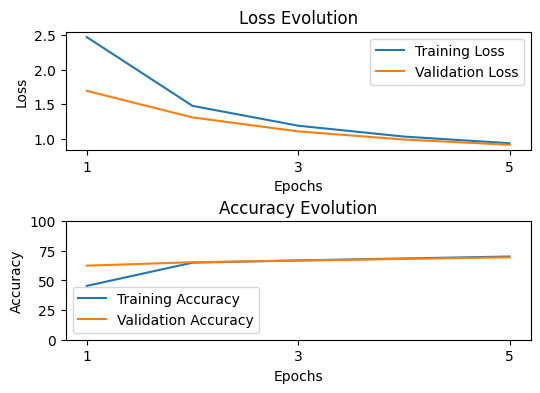

In [25]:
plt.figure(figsize=(6, 4))
# Plot Losses
plt.subplot(2, 1, 1)
plt.plot(range(1, params['num_epochs'] + 1), train_losses, label='Training Loss')
plt.plot(range(1, params['num_epochs'] + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution', fontsize=12)
plt.legend()
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x

# Plot Accuracies
plt.subplot(2, 1, 2)
plt.plot(range(1, params['num_epochs'] + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, params['num_epochs'] + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution', fontsize=12)
plt.legend()
plt.ylim(0, 100)  # Establecer los límites del eje y entre 0 y 100%
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x

plt.subplots_adjust(hspace=0.6)

plt.show()

It makes reasonable predictions for the images.

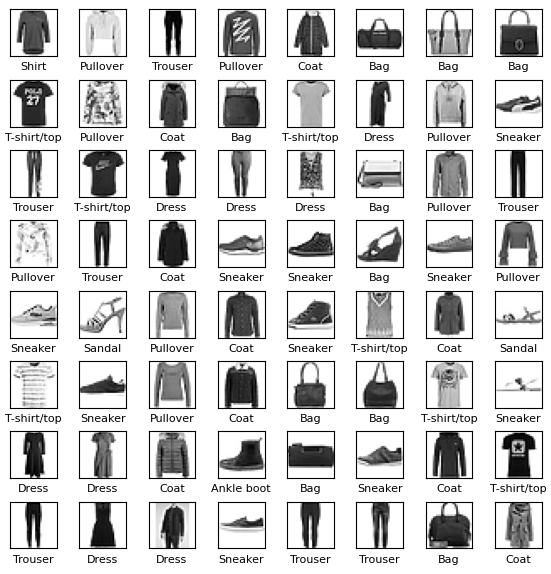

In [26]:
# Set the model to evaluation mode
model_advanced.eval()

# Make predictions
with torch.no_grad():
    val_images = val_images.to(device); val_labels = val_labels.to(device)
    outputs = model_advanced(val_images)
    val_images = val_images.cpu()
    _, predicted = torch.max(outputs.cpu(), 1)

# Create a grid of images
val_img_grid = make_grid(val_images)

# Plot grid
plt.figure(figsize=(7, 7))
for i in range(params['eval_batch_size']):
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_images[i].squeeze(), cmap=plt.cm.binary)  # Remove the channel dimension
    plt.xlabel(class_names[predicted[i].item()], fontsize=8)  # Use class names instead of numbers
plt.subplots_adjust(hspace=0.5)
plt.show()

Now the results are saved. In theory these weights would be published so the attacker could recover the finetuned version. 

In [27]:
archive_name = "model_finetuned_advanced_"+pretrained_version+".safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
save_file(model_advanced.state_dict(), saving_path)

## 4. References
All the work developed in these notebooks is based on the theoretical work done on following paper: 
- [1] [Privacy Backdoors: Stealing Data with Corrupted Pretrained Models](https://arxiv.org/abs/2404.00473) by Shanglun Feng, Florian Tramèr, 2024. Available at: [https://arxiv.org/abs/2404.00473](https://arxiv.org/abs/2404.00473)